# Load Image Set

In [2]:
import os
import cv2
import numpy as np
import math
from google.colab import drive
import matplotlib.pyplot as plt

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Check the directory structure to ensure the correct path
segmented_base_dir = "/content/drive/MyDrive/FYP/Lung/Segmented Images"

# Path to the directory containing segmented images
segmented_images_dir = os.path.join(segmented_base_dir, "Pneumothorax")
print(f"Using images directory: {segmented_images_dir}")

Using images directory: /content/drive/MyDrive/FYP/Lung/Segmented Images/Pneumothorax


In [5]:
# Check the directory structure to ensure the correct path
bone_suppressed_base_dir = "/content/drive/MyDrive/FYP/Lung/Bone Suppressed"

# Path to the directory containing segmented images
bone_suppressed_images_dir = os.path.join(bone_suppressed_base_dir, "Pneumothorax")
print(f"Using images directory: {bone_suppressed_images_dir}")

Using images directory: /content/drive/MyDrive/FYP/Lung/Bone Suppressed/Pneumothorax


# Pneumothorax Detection

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def detect_combined_homogeneous_area(image_path):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Step 1: Preprocess the image using GaussianBlur
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Step 2: Thresholding to create a binary image
    _, binary = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY_INV)  # Adjusted threshold value

    # Step 3: Morphological operations to clean up the binary image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Step 4: Find contours in the binary image
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an output image to draw detected areas
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Function to check if a contour area is homogeneous
    def is_homogeneous_area(contour, image):
        mask = np.zeros_like(image)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
        area_intensity = cv2.mean(image, mask=mask)[0]
        area_std_dev = np.std(image[mask == 255])
        return area_std_dev < 200  # Adjust the threshold for homogeneity

    # Function to separate low-contrast and high-contrast areas
    def separate_contrast_areas(contour, image):
        mask = np.zeros_like(image)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
        mean_intensity = cv2.mean(image, mask=mask)[0]
        return mean_intensity < 50  # Adjust the threshold for separating contrast areas

    # Step 5: Filter and identify the homogeneous areas
    detected_areas = []
    for contour in contours:
        if is_homogeneous_area(contour, image) and separate_contrast_areas(contour, image):
            detected_areas.append(contour)

    # Step 6: Create a mask for the detected homogeneous areas
    mask = np.zeros_like(image)
    for contour in detected_areas:
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

    # Step 7: Apply dilation followed by erosion to combine nearby areas
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))  # Adjust kernel size as needed
    dilated = cv2.dilate(mask, kernel, iterations=2)
    eroded = cv2.erode(dilated, kernel, iterations=2)

    # Step 8: Find the contour of the combined region
    combined_contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the combined contour on the output image
    if combined_contours:
        cv2.drawContours(output_image, combined_contours, -1, (0, 255, 255), 2)

    return combined_contours, output_image

def detect_pleural_line(image_path):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Step 1: Preprocess the image using GaussianBlur
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Step 2: Edge detection using Canny
    edges = cv2.Canny(blurred, 30, 150)  # Adjusted parameters for Canny edge detection

    # Step 3: Line detection using Hough Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=30, maxLineGap=10)

    # Create an output image to draw lines
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Function to check if a line is homogeneous
    def is_homogeneous_line(x1, y1, x2, y2, image):
        line_intensity = []
        num_points = max(abs(x2 - x1), abs(y2 - y1))
        for i in range(num_points + 1):
            x = int(x1 + i * (x2 - x1) / num_points)
            y = int(y1 + i * (y2 - y1) / num_points)
            line_intensity.append(image[y, x])

        if len(line_intensity) < 2:
            return False

        # Calculate the standard deviation of the intensities along the line
        std_dev = np.std(line_intensity)
        # Check if the line intensity is relatively consistent (low standard deviation)
        return std_dev < 20

    # Function to check if a line separates dark and light areas
    def separate_dark_light_areas(x1, y1, x2, y2, image):
        midpoint_x = (x1 + x2) // 2
        midpoint_y = (y1 + y2) // 2
        left_intensity = np.mean(image[max(0, midpoint_y - 5):midpoint_y + 5, max(0, midpoint_x - 20):midpoint_x])
        right_intensity = np.mean(image[max(0, midpoint_y - 5):midpoint_y + 5, midpoint_x:min(image.shape[1], midpoint_x + 20)])
        return abs(left_intensity - right_intensity) > 50

    # Step 4: Filter and identify the pleural line
    detected_lines = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if is_homogeneous_line(x1, y1, x2, y2, image) and separate_dark_light_areas(x1, y1, x2, y2, image):
                # Draw the detected pleural line on the output image
                cv2.line(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                detected_lines.append((x1, y1, x2, y2))

    return detected_lines

def detect_pneumothorax(segmented_image_path):
    combined_contours, output_image = detect_combined_homogeneous_area(segmented_image_path)

    if combined_contours:
        pleural_lines = detect_pleural_line(segmented_image_path)
        if pleural_lines:
            for line in pleural_lines:
                x1, y1, x2, y2 = line
                # Check if the pleural line is near the homogeneous area
                for contour in combined_contours:
                    if cv2.pointPolygonTest(np.array(contour, dtype=np.float32), ((x1 + x2) / 2, (y1 + y2) / 2), False) >= 0:
                        print(f"Pneumothorax likely present in image: {segmented_image_path}")
                        return True

    print(f"No significant pleural lines detected, Pneumothorax unlikely in image: {segmented_image_path}")
    return False

def iterate_through_images(directory):
    files = os.listdir(directory)
    image_files = [file for file in files if file.endswith('.jpg') or file.endswith('.png')]
    results = []
    for image_file in image_files:
        image_path = os.path.join(directory, image_file)
        result = detect_pneumothorax(image_path)
        results.append(result)
    return results

# Directory containing the segmented lung images
image_directory = '/content/drive/MyDrive/FYP/Lung/Segmented Images/Pneumothorax'

# Get the detection results for all images
detection_results = iterate_through_images(image_directory)

# Calculate accuracy
TP = sum(detection_results)  # Number of True Positives
all_images = len(detection_results)  # Total number of images

accuracy = TP / all_images if all_images > 0 else 0
print('Accuracy:', accuracy)


Pneumothorax likely present in image: /content/drive/MyDrive/FYP/Lung/Segmented Images/Pneumothorax/segmented_104.png
No significant pleural lines detected, Pneumothorax unlikely in image: /content/drive/MyDrive/FYP/Lung/Segmented Images/Pneumothorax/segmented_113.png
No significant pleural lines detected, Pneumothorax unlikely in image: /content/drive/MyDrive/FYP/Lung/Segmented Images/Pneumothorax/segmented_105.png
No significant pleural lines detected, Pneumothorax unlikely in image: /content/drive/MyDrive/FYP/Lung/Segmented Images/Pneumothorax/segmented_83.png
Pneumothorax likely present in image: /content/drive/MyDrive/FYP/Lung/Segmented Images/Pneumothorax/segmented_96.png
Pneumothorax likely present in image: /content/drive/MyDrive/FYP/Lung/Segmented Images/Pneumothorax/segmented_56.png
No significant pleural lines detected, Pneumothorax unlikely in image: /content/drive/MyDrive/FYP/Lung/Segmented Images/Pneumothorax/segmented_107.png
Pneumothorax likely present in image: /conten

In [22]:
import cv2
import numpy as np
import os

def extract_pneumothorax_features(image_path):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Preprocess the image using GaussianBlur
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Edge detection using Canny
    edges = cv2.Canny(blurred, 30, 150)

    # Line detection using Hough Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=30, maxLineGap=10)

    features = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            features.extend([x1, y1, x2, y2])

    # Normalize the feature vector to have consistent size
    max_features = 100  # Adjust based on expected maximum number of features
    features = features[:max_features]  # Trim to max_features length
    features.extend([0] * (max_features - len(features)))  # Pad with zeros if less than max_features

    return np.array(features)

# Example usage
image_path = '/content/drive/MyDrive/FYP/Lung/Segmented Images/Pneumothorax/Copy of segmented_43.png'
features = extract_pneumothorax_features(image_path)
print(features)


[694 290 793 340 304 307 396 358 713 819 753 868 613 367 739 319 741 320
 811 355 811 573 835 660 823 730 840 799 104 883 120 843 144 783 157 747
 253 357 292 348 580 510 583 474 693 656 746 687 160 745 172 713 628 462
 670 455 584 213 607 176 162 870 230 848 415 205 450 240 672 769 710 809
 586 303 631 269 692 655 742 684 757 392 793 412 684 294 750 268 607 388
 667 377 184 412 220 376 331 232 368 238]


# Plural Effusion Detection

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_costophrenic_angles_edges(image_path):
    # Load the X-ray image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Could not load image at path: {image_path}")

    # Apply histogram equalization for better contrast
    image_eq = cv2.equalizeHist(image)

    # Thresholding to get binary image
    _, binary = cv2.threshold(image_eq, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour which should correspond to the lung area
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a mask from the largest contour
    mask = np.zeros_like(image)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # Find the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Extract the lower part of the lung where the costophrenic angles are located
    lung_bottom = mask[y + h // 2:y + h, x:x + w]

    # Extract left and right costophrenic angles (lower corners)
    h_bottom, w_bottom = lung_bottom.shape
    left_costophrenic_angle = lung_bottom[h_bottom // 2:, :w_bottom // 2]
    right_costophrenic_angle = lung_bottom[h_bottom // 2:, w_bottom // 2:]

    # Apply Canny edge detection
    left_edges = cv2.Canny(left_costophrenic_angle, 100, 200)
    right_edges = cv2.Canny(right_costophrenic_angle, 100, 200)

    # Display the results
    # plt.figure(figsize=(12, 6))
    # plt.subplot(2, 3, 1)
    # plt.imshow(image, cmap='gray')
    # plt.title('Original Image')

    # plt.subplot(2, 3, 2)
    # plt.imshow(left_costophrenic_angle, cmap='gray')
    # plt.title('Left Costophrenic Angle')

    # plt.subplot(2, 3, 3)
    # plt.imshow(right_costophrenic_angle, cmap='gray')
    # plt.title('Right Costophrenic Angle')

    # plt.subplot(2, 3, 5)
    # plt.imshow(left_edges, cmap='gray')
    # plt.title('Left Bottom Corner Edges')

    # plt.subplot(2, 3, 6)
    # plt.imshow(right_edges, cmap='gray')
    # plt.title('Right Bottom Corner Edges')

    # plt.show()

    return left_edges, right_edges

# Example usage
#left_edges, right_edges = extract_costophrenic_angles_edges("/content/drive/MyDrive/FYP/Lung/Segmented Images/effusion1.png")
#left_edges, right_edges = extract_costophrenic_angles_edges("/content/drive/MyDrive/FYP/Lung/Segmented Images/Effusion/segmented_0.png")
left_edges, right_edges = extract_costophrenic_angles_edges("/content/drive/MyDrive/FYP/Lung/Segmented Images/Effusion/segmented_87.png")



In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_costophrenic_angles_edges(image_path):
    # Load the X-ray image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Could not load image at path: {image_path}")

    # Apply histogram equalization for better contrast
    image_eq = cv2.equalizeHist(image)

    # Thresholding to get binary image
    _, binary = cv2.threshold(image_eq, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour which should correspond to the lung area
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a mask from the largest contour
    mask = np.zeros_like(image)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # Find the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Extract the lower part of the lung where the costophrenic angles are located
    lung_bottom = mask[y + h // 2:y + h, x:x + w]

    # Extract left and right costophrenic angles (lower corners)
    h_bottom, w_bottom = lung_bottom.shape
    left_costophrenic_angle = lung_bottom[h_bottom // 2:, :w_bottom // 2]
    right_costophrenic_angle = lung_bottom[h_bottom // 2:, w_bottom // 2:]

    # Apply Canny edge detection
    left_edges = cv2.Canny(left_costophrenic_angle, 50, 150)
    right_edges = cv2.Canny(right_costophrenic_angle, 50, 150)

    # Display the results
    # plt.figure(figsize=(12, 6))
    # plt.subplot(2, 3, 1)
    # plt.imshow(image, cmap='gray')
    # plt.title('Original Image')

    # plt.subplot(2, 3, 2)
    # plt.imshow(left_costophrenic_angle, cmap='gray')
    # plt.title('Left Costophrenic Angle')

    # plt.subplot(2, 3, 3)
    # plt.imshow(right_costophrenic_angle, cmap='gray')
    # plt.title('Right Costophrenic Angle')

    # plt.subplot(2, 3, 5)
    # plt.imshow(left_edges, cmap='gray')
    # plt.title('Left Bottom Corner Edges')

    # plt.subplot(2, 3, 6)
    # plt.imshow(right_edges, cmap='gray')
    # plt.title('Right Bottom Corner Edges')

    # plt.show()

    return left_edges, right_edges

def calculate_angle(edges):
    # Find lines using Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=20, minLineLength=10, maxLineGap=5)
    if lines is None:
        raise ValueError("No lines detected")

    # Extract the first two lines
    if len(lines) < 2:
        raise ValueError("Not enough lines detected to calculate angle")

    line1 = lines[0][0]
    line2 = lines[1][0]

    # Calculate the angles of the lines
    angle1 = np.arctan2(line1[3] - line1[1], line1[2] - line1[0])
    angle2 = np.arctan2(line2[3] - line2[1], line2[2] - line2[0])

    # Calculate the angle between the two lines
    angle_between_lines = np.abs(angle1 - angle2)
    angle_between_lines = np.degrees(angle_between_lines)

    if angle_between_lines > 180:
        angle_between_lines = 360 - angle_between_lines

    return angle_between_lines

def find_angle(left_edges, right_edges):
    try:
        left_angle = calculate_angle(left_edges)
        right_angle = calculate_angle(right_edges)

        return left_angle, right_angle
    except Exception as e:
        print(f"Error calculating angles: {e}")
        return None, None

# Example usage
left_edges, right_edges = extract_costophrenic_angles_edges("/content/drive/MyDrive/FYP/Lung/Segmented Images/Effusion/segmented_87.png")
left_angle, right_angle = find_angle(left_edges, right_edges)
print(f"Left Costophrenic Angle: {left_angle} degrees")
print(f"Right Costophrenic Angle: {right_angle} degrees")


Left Costophrenic Angle: 69.04422326936782 degrees
Right Costophrenic Angle: 82.8749836510982 degrees


In [9]:
def is_blunted(left_edges, right_edges):
    try:
        threshold=90
        left_angle = calculate_angle(left_edges)
        right_angle = calculate_angle(right_edges)

        print(f"Left Costophrenic Angle: {left_angle} degrees")
        print(f"Right Costophrenic Angle: {right_angle} degrees")

        left_blunted = left_angle > threshold
        right_blunted = right_angle > threshold

        print(f"Left Costophrenic Angle Blunted: {left_blunted}")
        print(f"Right Costophrenic Angle Blunted: {right_blunted}")

        return left_blunted, right_blunted
    except Exception as e:
        print(f"Error calculating angles: {e}")
        return None, None

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_whiteness_area_at_base(image_path):
    # Load the X-ray image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Could not load image at path: {image_path}")

    # Apply histogram equalization for better contrast
    image_eq = cv2.equalizeHist(image)

    # Thresholding to get binary image
    _, binary = cv2.threshold(image_eq, 200, 255, cv2.THRESH_BINARY)  # Adjust threshold value as needed

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour which should correspond to the lung area
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a mask from the largest contour
    mask = np.zeros_like(image)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # Extract the lower part of the lung where pleural effusion is typically located
    lung_bottom_mask = np.zeros_like(mask)
    h = mask.shape[0]
    lung_bottom_mask[h // 2:h, :] = 255

    # Apply the mask to the binary image to focus on the lung region
    masked_binary = cv2.bitwise_and(binary, binary, mask=lung_bottom_mask)

    # Apply dilation followed by erosion to smooth the contours
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))  # Adjust kernel size as needed
    dilated = cv2.dilate(masked_binary, kernel, iterations=2)
    eroded = cv2.erode(dilated, kernel, iterations=2)

    # Find the contour of the combined region
    combined_contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by their bottommost point (y-coordinate) and area
    sorted_contours = sorted(combined_contours, key=lambda c: (cv2.boundingRect(c)[1] + cv2.boundingRect(c)[3], cv2.contourArea(c)), reverse=True)[:2]

    # Calculate the area of the whiteness and approximate contours
    whiteness_area = 0
    approx_contours = []
    for contour in sorted_contours:
        whiteness_area += cv2.contourArea(contour)
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        approx_contours.append(approx)

    # Draw the approximated whiteness contours on the original image
    image_with_contours = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to BGR for colored contour drawing
    cv2.drawContours(image_with_contours, approx_contours, -1, (0, 0, 255), 2)  # Draw contours in red

    # Display the results
    # plt.figure(figsize=(12, 6))
    # plt.subplot(2, 3, 1)
    # plt.imshow(image, cmap='gray')
    # plt.title('Original Image')

    # plt.subplot(2, 3, 2)
    # plt.imshow(image_eq, cmap='gray')
    # plt.title('Histogram Equalized Image')

    # plt.subplot(2, 3, 3)
    # plt.imshow(binary, cmap='gray')
    # plt.title('Thresholded Image')

    # plt.subplot(2, 3, 4)
    # plt.imshow(masked_binary, cmap='gray')
    # plt.title('Masked Binary Image')

    # plt.subplot(2, 3, 5)
    # plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
    # plt.title('Contours on Original Image')

    # plt.show()

    return whiteness_area

# Example usage
whiteness_area = find_whiteness_area_at_base("/content/drive/MyDrive/FYP/Lung/Segmented Images/Effusion/segmented_87.png")
print(f"Whiteness area at the base of the lung: {whiteness_area} pixels")


Whiteness area at the base of the lung: 29900.0 pixels


In [11]:
def check_whiteness_consistency(image_path, threshold_area=10000):
    # Calculate the whiteness area and approximated contours
    whiteness_area = find_whiteness_area_at_base(image_path)

    # Check if the whiteness area is above the threshold
    is_whiteness_consistent = whiteness_area > threshold_area

    # Print results
    print(f"Whiteness area at the base of the lung: {whiteness_area} pixels")
    if is_whiteness_consistent:
        print("The whiteness areas are consistent.")
    else:
        print("The whiteness areas are not consistent.")

    # Return consistency result
    return is_whiteness_consistent


In [12]:
def predict_effusion(left_blunted, right_blunted, is_whiteness_consistent):
    if left_blunted or right_blunted or is_whiteness_consistent:
        result = True  # Pleural effusion suspected
        message = "Pleural effusion is suspected. The costophrenic angle is blunted or whiteness areas are consistent."
    else:
        result = False  # No pleural effusion suspected
        message = "No pleural effusion suspected. Either the costophrenic angle is not blunted or the whiteness areas are not consistent."

    print(message)
    return result


In [13]:
import os

def iterate_through_images(directory):
    results = []
    image_files = [f for f in os.listdir(directory) if f.endswith('.png')]  # Adjust the file extension as needed

    for image_file in image_files:
        image_path = os.path.join(directory, image_file)

        # Determine if whiteness areas are consistent
        is_whiteness_consistent = check_whiteness_consistency(image_path)

        # Extract costophrenic angles and whiteness data
        left_edges, right_edges = extract_costophrenic_angles_edges(image_path)
        left_blunted, right_blunted = is_blunted(left_edges, right_edges)

        # Predict effusion
        result = predict_effusion(left_blunted, right_blunted, is_whiteness_consistent)
        results.append(result)

    return results

In [14]:
# Directory containing the segmented lung images
image_directory = '/content/drive/MyDrive/FYP/Lung/Segmented Images/Effusion'

# Get the detection results for all images
detection_results = iterate_through_images(image_directory)


Whiteness area at the base of the lung: 2997.5 pixels
The whiteness areas are not consistent.
Error calculating angles: Not enough lines detected to calculate angle
No pleural effusion suspected. Either the costophrenic angle is not blunted or the whiteness areas are not consistent.
Whiteness area at the base of the lung: 33247.5 pixels
The whiteness areas are consistent.
Error calculating angles: No lines detected
Pleural effusion is suspected. The costophrenic angle is blunted or whiteness areas are consistent.
Whiteness area at the base of the lung: 3.5 pixels
The whiteness areas are not consistent.
Error calculating angles: No lines detected
No pleural effusion suspected. Either the costophrenic angle is not blunted or the whiteness areas are not consistent.
Whiteness area at the base of the lung: 24341.5 pixels
The whiteness areas are consistent.
Left Costophrenic Angle: 70.4283792994792 degrees
Right Costophrenic Angle: 22.24902365721236 degrees
Left Costophrenic Angle Blunted: F

In [15]:
# Calculate accuracy
TP = sum(detection_results)  # Number of True Positives
all_images = len(detection_results)  # Total number of images

accuracy = TP / all_images if all_images > 0 else 0
print('Accuracy:', accuracy)

Accuracy: 0.6036585365853658


In [23]:
import cv2
import numpy as np
import os

def extract_effusion_features(image_path):
    # Function to extract costophrenic angles edges
    def extract_costophrenic_angles_edges(image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Could not load image at path: {image_path}")

        image_eq = cv2.equalizeHist(image)
        _, binary = cv2.threshold(image_eq, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(image)
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
        x, y, w, h = cv2.boundingRect(largest_contour)
        lung_bottom = mask[y + h // 2:y + h, x:x + w]
        h_bottom, w_bottom = lung_bottom.shape
        left_costophrenic_angle = lung_bottom[h_bottom // 2:, :w_bottom // 2]
        right_costophrenic_angle = lung_bottom[h_bottom // 2:, w_bottom // 2:]
        left_edges = cv2.Canny(left_costophrenic_angle, 50, 150)
        right_edges = cv2.Canny(right_costophrenic_angle, 50, 150)
        return left_edges, right_edges

    # Function to calculate angle between two lines
    def calculate_angle(edges):
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=20, minLineLength=10, maxLineGap=5)
        if lines is None:
            raise ValueError("No lines detected")
        if len(lines) < 2:
            raise ValueError("Not enough lines detected to calculate angle")
        line1 = lines[0][0]
        line2 = lines[1][0]
        angle1 = np.arctan2(line1[3] - line1[1], line1[2] - line1[0])
        angle2 = np.arctan2(line2[3] - line2[1], line2[2] - line2[0])
        angle_between_lines = np.abs(angle1 - angle2)
        angle_between_lines = np.degrees(angle_between_lines)
        if angle_between_lines > 180:
            angle_between_lines = 360 - angle_between_lines
        return angle_between_lines

    # Function to check if costophrenic angles are blunted
    def is_blunted(left_edges, right_edges):
        threshold = 90
        try:
            left_angle = calculate_angle(left_edges)
            right_angle = calculate_angle(right_edges)
            left_blunted = left_angle > threshold
            right_blunted = right_angle > threshold
            return left_blunted, right_blunted
        except Exception as e:
            return None, None

    # Function to find the whiteness area at the base of the lung
    def find_whiteness_area_at_base(image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Could not load image at path: {image_path}")
        image_eq = cv2.equalizeHist(image)
        _, binary = cv2.threshold(image_eq, 200, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(image)
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
        lung_bottom_mask = np.zeros_like(mask)
        h = mask.shape[0]
        lung_bottom_mask[h // 2:h, :] = 255
        masked_binary = cv2.bitwise_and(binary, binary, mask=lung_bottom_mask)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
        dilated = cv2.dilate(masked_binary, kernel, iterations=2)
        eroded = cv2.erode(dilated, kernel, iterations=2)
        combined_contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        sorted_contours = sorted(combined_contours, key=lambda c: (cv2.boundingRect(c)[1] + cv2.boundingRect(c)[3], cv2.contourArea(c)), reverse=True)[:2]
        whiteness_area = sum(cv2.contourArea(contour) for contour in sorted_contours)
        return whiteness_area

    # Extract features
    left_edges, right_edges = extract_costophrenic_angles_edges(image_path)
    left_blunted, right_blunted = is_blunted(left_edges, right_edges)
    whiteness_area = find_whiteness_area_at_base(image_path)
    is_whiteness_consistent = whiteness_area > 10000  # Adjust threshold as needed

    # Combine features into a single feature vector
    features = [
        int(left_blunted) if left_blunted is not None else 0,
        int(right_blunted) if right_blunted is not None else 0,
        whiteness_area,
        int(is_whiteness_consistent)
    ]

    return np.array(features)

# Example usage
image_path = '/content/drive/MyDrive/FYP/Lung/Segmented Images/Effusion/segmented_87.png'
features = extract_effusion_features(image_path)
print(features)


[0.00e+00 0.00e+00 2.99e+04 1.00e+00]


# Model Training

## Data Preparation

In [25]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def extract_combined_features(image_path):
    # Combine features from pneumothorax and effusion
    pneumothorax_features = extract_pneumothorax_features(image_path)
    effusion_features = extract_effusion_features(image_path)
    combined_features = np.concatenate((pneumothorax_features, effusion_features))
    return combined_features

# Data directory and labels
data_dir = '/content/drive/MyDrive/FYP/Lung/Segmented Images'
folders_to_process = ['Pneumothorax', 'Effusion']
features_list = []
labels_list = []

# Iterate through the folders and extract features
for label in folders_to_process:
    folder_path = os.path.join(data_dir, label)
    for file in os.listdir(folder_path):
        if file.endswith(('png', 'jpg', 'jpeg')):
            image_path = os.path.join(folder_path, file)
            features = extract_combined_features(image_path)
            features_list.append(features)
            labels_list.append(label)

# Convert lists to numpy arrays
X = np.array(features_list)
y = np.array(labels_list)

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


## Define a Model

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Adjust the output layer for the number of classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


## Train the Model

In [27]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/10
13/13 [==============================] - 1s 18ms/step - loss: 762.9546 - accuracy: 0.5844 - val_loss: 292.7605 - val_accuracy: 0.7282
Epoch 2/10
13/13 [==============================] - 0s 5ms/step - loss: 597.2191 - accuracy: 0.5501 - val_loss: 188.4998 - val_accuracy: 0.6699
Epoch 3/10
13/13 [==============================] - 0s 5ms/step - loss: 403.8778 - accuracy: 0.5672 - val_loss: 199.3375 - val_accuracy: 0.7087
Epoch 4/10
13/13 [==============================] - 0s 7ms/step - loss: 347.5698 - accuracy: 0.5648 - val_loss: 128.7530 - val_accuracy: 0.7379
Epoch 5/10
13/13 [==============================] - 0s 6ms/step - loss: 229.1020 - accuracy: 0.5746 - val_loss: 110.1704 - val_accuracy: 0.7282
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 185.6757 - accuracy: 0.5697 - val_loss: 86.0337 - val_accuracy: 0.7282
Epoch 7/10
13/13 [==============================] - 0s 5ms/step - loss: 137.4660 - accuracy: 0.5721 - val_loss: 69.8711 - val_accuracy: 

# Evaluation

In [28]:
# Evaluate the model
evaluation = model.evaluate(X_test, y_test)
print(f'Validation Loss: {evaluation[0]}')
print(f'Validation Accuracy: {evaluation[1]}')

4/4 [==============================] - 0s 3ms/step - loss: 26.9341 - accuracy: 0.7379
Validation Loss: 26.934070587158203
Validation Accuracy: 0.737864077091217


In [30]:
from sklearn.metrics import classification_report

# Predict the classes for the test data
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Print classification report
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

4/4 [==============================] - 0s 5ms/step
Neural Network Classification Report:
              precision    recall  f1-score   support

    Effusion       0.60      0.11      0.18        28
Pneumothorax       0.74      0.97      0.84        75

    accuracy                           0.74       103
   macro avg       0.67      0.54      0.51       103
weighted avg       0.71      0.74      0.66       103



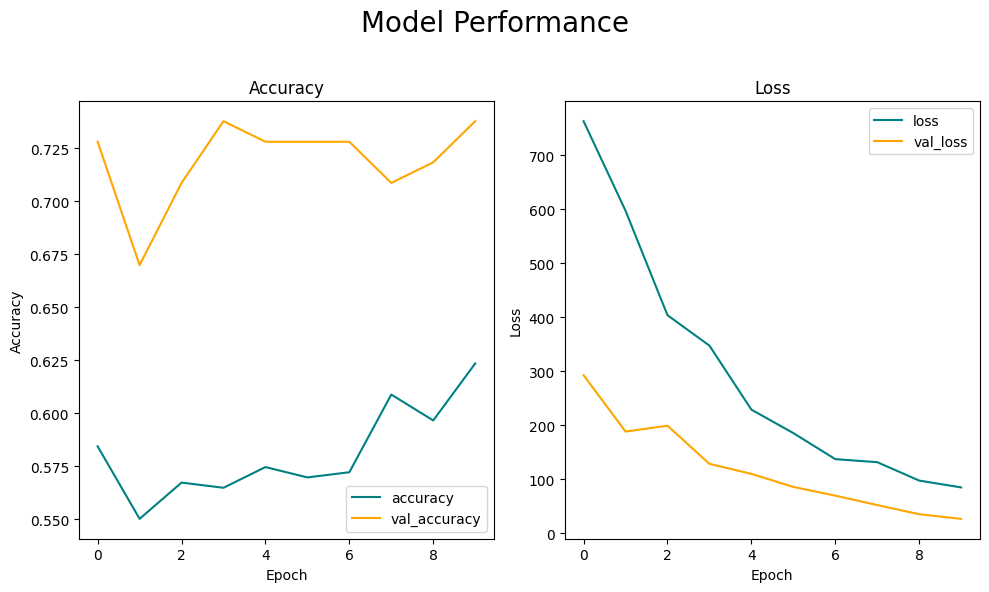

In [53]:
# Create a new figure
fig = plt.figure(figsize=(10, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Set a title for the entire figure
fig.suptitle('Model Performance', fontsize=20)

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the suptitle
plt.show()


# Manifestation

In [40]:
import cv2
import numpy as np

# Function to extract pneumothorax features
def extract_pneumothorax_features(image_path):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Preprocess the image using GaussianBlur
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Edge detection using Canny
    edges = cv2.Canny(blurred, 30, 150)

    # Line detection using Hough Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=30, maxLineGap=10)

    features = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            features.extend([x1, y1, x2, y2])

    # Normalize the feature vector to have consistent size
    max_features = 100  # Adjust based on expected maximum number of features
    features = features[:max_features]  # Trim to max_features length
    features.extend([0] * (max_features - len(features)))  # Pad with zeros if less than max_features

    return np.array(features)

# Function to extract effusion features
def extract_effusion_features(image_path):
    # Function to extract costophrenic angles edges
    def extract_costophrenic_angles_edges(image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Could not load image at path: {image_path}")

        image_eq = cv2.equalizeHist(image)
        _, binary = cv2.threshold(image_eq, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(image)
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
        x, y, w, h = cv2.boundingRect(largest_contour)
        lung_bottom = mask[y + h // 2:y + h, x:x + w]
        h_bottom, w_bottom = lung_bottom.shape
        left_costophrenic_angle = lung_bottom[h_bottom // 2:, :w_bottom // 2]
        right_costophrenic_angle = lung_bottom[h_bottom // 2:, w_bottom // 2:]
        left_edges = cv2.Canny(left_costophrenic_angle, 50, 150)
        right_edges = cv2.Canny(right_costophrenic_angle, 50, 150)
        return left_edges, right_edges

    # Function to calculate angle between two lines
    def calculate_angle(edges):
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=20, minLineLength=10, maxLineGap=5)
        if lines is None:
            raise ValueError("No lines detected")
        if len(lines) < 2:
            raise ValueError("Not enough lines detected to calculate angle")
        line1 = lines[0][0]
        line2 = lines[1][0]
        angle1 = np.arctan2(line1[3] - line1[1], line1[2] - line1[0])
        angle2 = np.arctan2(line2[3] - line2[1], line2[2] - line2[0])
        angle_between_lines = np.abs(angle1 - angle2)
        angle_between_lines = np.degrees(angle_between_lines)
        if angle_between_lines > 180:
            angle_between_lines = 360 - angle_between_lines
        return angle_between_lines

    # Function to check if costophrenic angles are blunted
    def is_blunted(left_edges, right_edges):
        threshold = 90
        try:
            left_angle = calculate_angle(left_edges)
            right_angle = calculate_angle(right_edges)
            left_blunted = left_angle > threshold
            right_blunted = right_angle > threshold
            return left_blunted, right_blunted
        except Exception as e:
            return None, None

    # Function to find the whiteness area at the base of the lung
    def find_whiteness_area_at_base(image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Could not load image at path: {image_path}")
        image_eq = cv2.equalizeHist(image)
        _, binary = cv2.threshold(image_eq, 200, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(image)
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
        lung_bottom_mask = np.zeros_like(mask)
        h = mask.shape[0]
        lung_bottom_mask[h // 2:h, :] = 255
        masked_binary = cv2.bitwise_and(binary, binary, mask=lung_bottom_mask)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
        dilated = cv2.dilate(masked_binary, kernel, iterations=2)
        eroded = cv2.erode(dilated, kernel, iterations=2)
        combined_contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        sorted_contours = sorted(combined_contours, key=lambda c: (cv2.boundingRect(c)[1] + cv2.boundingRect(c)[3], cv2.contourArea(c)), reverse=True)[:2]
        whiteness_area = sum(cv2.contourArea(contour) for contour in sorted_contours)
        return whiteness_area

    # Extract features
    left_edges, right_edges = extract_costophrenic_angles_edges(image_path)
    left_blunted, right_blunted = is_blunted(left_edges, right_edges)
    whiteness_area = find_whiteness_area_at_base(image_path)
    is_whiteness_consistent = whiteness_area > 10000  # Adjust threshold as needed

    # Combine features into a single feature vector
    features = [
        int(left_blunted) if left_blunted is not None else 0,
        int(right_blunted) if right_blunted is not None else 0,
        whiteness_area,
        int(is_whiteness_consistent)
    ]

    return np.array(features)

# Function to extract combined features for an input image
def extract_combined_features(image_path):
    pneumothorax_features = extract_pneumothorax_features(image_path)
    effusion_features = extract_effusion_features(image_path)
    combined_features = np.concatenate((pneumothorax_features, effusion_features))
    return combined_features


In [46]:
import tensorflow as tf
import numpy as np

# Load the trained model
# model = tf.keras.models.load_model('path_to_your_saved_model')  # Uncomment this line if loading a saved model

# Example input image
#image_path = '/content/drive/MyDrive/FYP/Lung/Segmented Images/Effusion/segmented_95.png'
#image_path = '/content/drive/MyDrive/FYP/Lung/Segmented Images/Effusion/segmented_97.png'
image_path = '/content/drive/MyDrive/FYP/Lung/Segmented Images/Pneumothorax/Copy of segmented_6.png'

# Extract features from the input image
input_features = extract_combined_features(image_path)
input_features = input_features.reshape(1, -1)  # Reshape for a single sample

# Predict the class for the input image
predicted_prob = model.predict(input_features)
predicted_class = np.argmax(predicted_prob, axis=1)
max_prob = np.max(predicted_prob)

# Set a confidence threshold
confidence_threshold = 0.6  # Adjust the threshold as needed

# Interpret the result
if max_prob < confidence_threshold:
    predicted_label = "Cannot suspect"
else:
    class_labels = label_encoder.classes_
    predicted_label = class_labels[predicted_class[0]]

print(f'The input image is suspected as: {predicted_label}')


1/1 [==============================] - 0s 29ms/step
The input image is suspected as: Pneumothorax
